# Model Prep

In [1]:
# Dependencies
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import math

In [2]:
# Location files
features_loc = "../dataset/validate_feat.pickle"
target_loc = "../dataset/validate_target.pickle"

In [3]:
features_df = pd.read_pickle(features_loc)
target_df = pd.read_pickle(target_loc)

## Check for missing values

In [5]:
# Check NA in target df
print(target_df.isna().sum())
#Only one in PERMA and HAP, look at the row
with pd.option_context('display.max_columns', None):
    display(target_df[target_df["PERMA"].isna()])

id                 0
gender             0
born               0
education          0
employed           0
income             0
A_2                0
N_1                0
P_1                0
E_1                0
A_1                0
H_1                0
M_1                0
R_1                0
M_2                0
E_2                0
LON                0
H_2                0
P_2                0
N_2                0
A_3                0
N_3                0
E_3                0
H_3                0
R_2                0
M_3                0
R_3                0
P_3                0
HAP                0
participate        0
insta_user_id      0
completed          0
start_q            0
end_q              0
network_id         0
P                  0
E                  0
R                  0
M                  0
A                  0
PERMA              0
N_EMO              0
P_EMO              0
imagecount         0
private_account    0
dtype: int64


,id,gender,born,education,employed,income,A_2,N_1,P_1,E_1,A_1,H_1,M_1,R_1,M_2,E_2,LON,H_2,P_2,N_2,A_3,N_3,E_3,H_3,R_2,M_3,R_3,P_3,HAP,participate,insta_user_id,completed,start_q,end_q,network_id,P,E,R,M,A,PERMA,N_EMO,P_EMO,imagecount,private_account


In [129]:
# # Impute hapiness by median of all values 
# target_df.loc[target_df["PERMA"].isna(),"HAP"]  = target_df["HAP"].median()

In [6]:
# Create vector for columns of questions
questions = list(target_df.columns[6:29])
questions.remove('LON')
questions = [q for q in questions if q not in ('LON', 'N_1', 'N_2', 'N_3','H_1', 'H_2', 'H_3')]
questions.sort()
print(questions)

['A_1', 'A_2', 'A_3', 'E_1', 'E_2', 'E_3', 'HAP', 'M_1', 'M_2', 'M_3', 'P_1', 'P_2', 'P_3', 'R_1', 'R_2', 'R_3']


In [7]:
# # Calculate PERMA score using mean of all questions
# target_df.loc[target_df["PERMA"].isna(),"PERMA"] =  target_df.loc[target_df["PERMA"].isna(),
#                                                                   questions].mean(axis = 1)
# Check if all individual questions aa up to the PERMA score
(target_df[questions].mean(axis = 1) == target_df["PERMA"]).mean()

1.0

In [8]:
# Check missing values of features
features_df.isnull().sum()

image_height                  0
image_width                   0
data_memorability             0
user_followed_by              0
user_follows                  0
user_posted_photos            0
age                           3
glasses                       3
face_emotion_ANGRY            3
face_emotion_CALM             3
face_emotion_CONFUSED         3
face_emotion_DISGUSTED        3
face_emotion_HAPPY            3
face_emotion_SAD              3
face_emotion_SURPRISED        3
facial_hear                   3
smile                         3
unkown_gender                 3
male                          3
female                        3
anp_sentiment                 0
emotion_score                 0
emotion_label_acceptance      0
emotion_label_admiration      0
emotion_label_amazement       0
emotion_label_anger           0
emotion_label_annoyance       0
emotion_label_anticipation    0
emotion_label_apprehension    0
emotion_label_boredom         0
emotion_label_disgust         0
emotion_

In [10]:
# 3 people did not have any faces in their data. All values will be imputed to 0
features_df = features_df.fillna(0)
features_df.isnull().sum().sum()

0

## Check Histograms

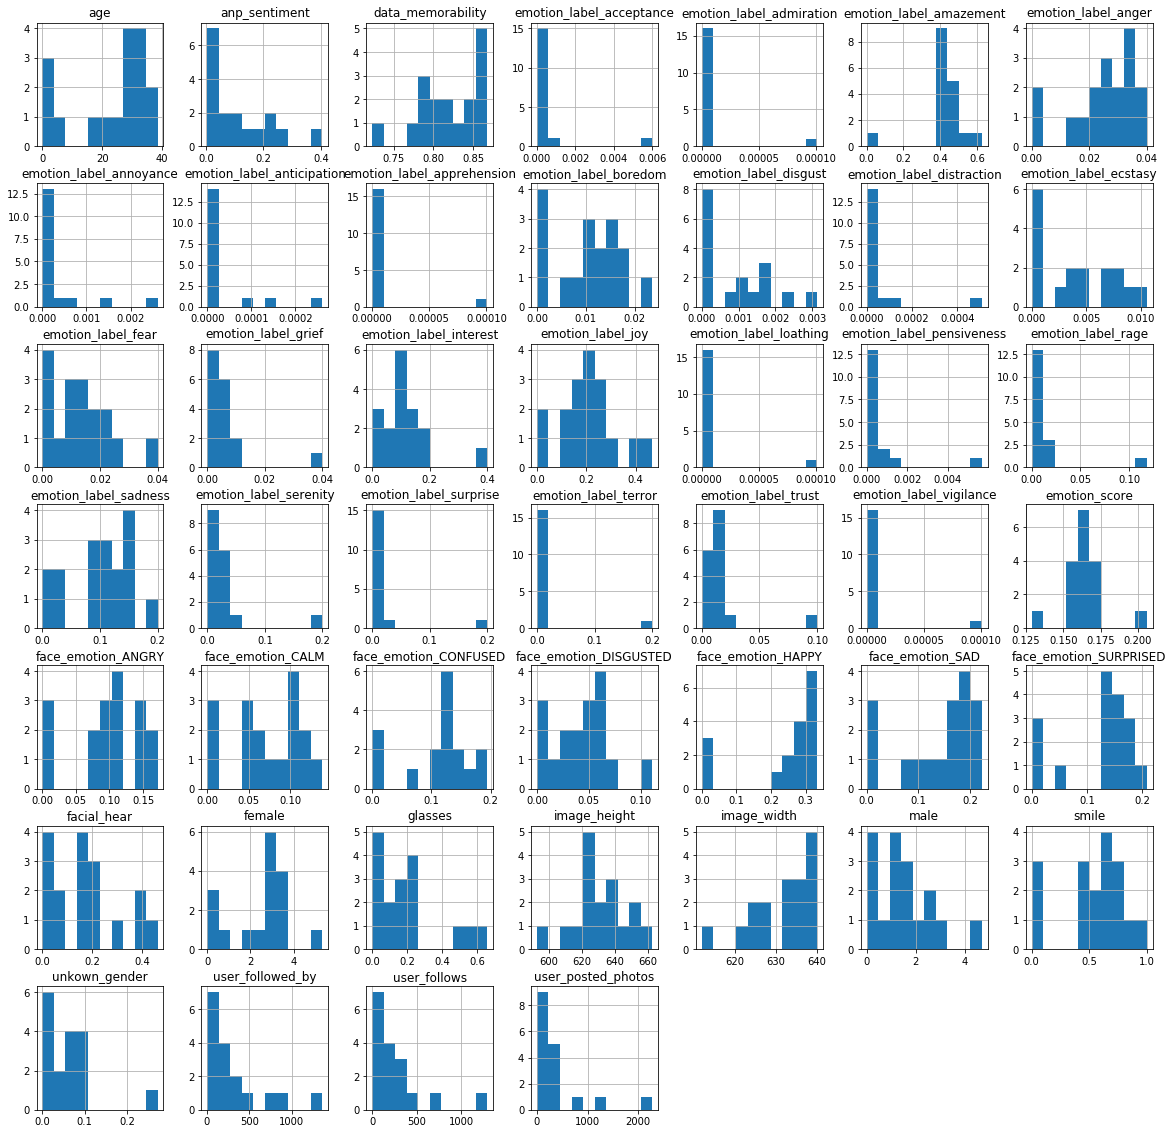

In [11]:
features_df.hist(figsize= (20,20))
plt.show()

In [12]:
# Select all values not equal to 0 to perform log transform
values_to_transform = ["user_followed_by" , "user_follows","user_posted_photos"]
for value in values_to_transform:
    select_log_transform = (features_df.loc[:,[value]] != 0)[value]
    features_df.loc[select_log_transform,[value]] = np.log10(features_df.loc[select_log_transform,[value]])

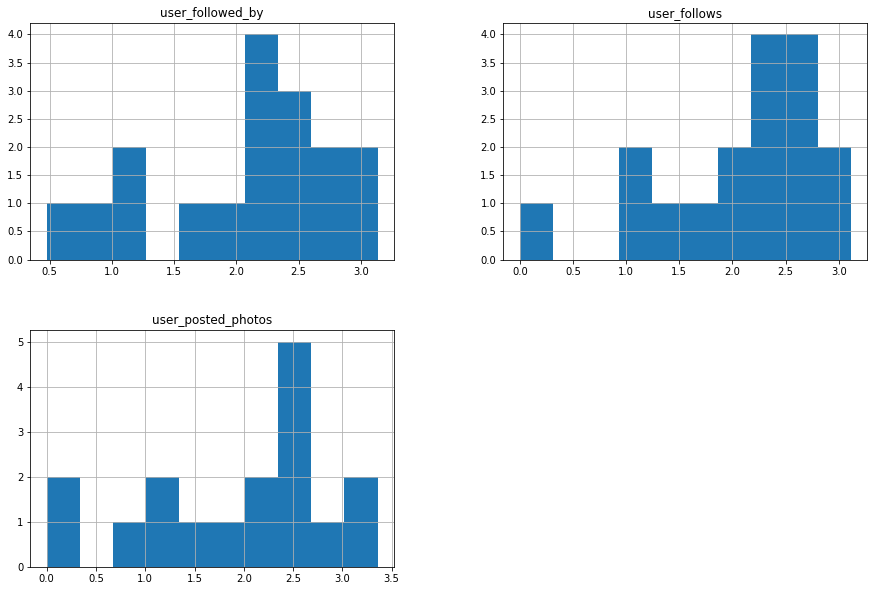

In [13]:
features_df.loc[:,values_to_transform].hist(figsize= (15,10))
plt.show()

## Check correlation of features

In [14]:
# corrMatrix = features_df.corr()
# corrMatrix.style.applymap(lambda x: 'color:green' if x > 0.65 else 'color:red')

In [15]:
# corrMatrixspear = features_df.corr(method="spearman")
# corrMatrixspear.style.applymap(lambda x: 'color:green' if x > 0.65 else 'color:red')

In [16]:
# # Select combinations of correlated pairs and drop the one that is least correlated with target_df["PERMA"]  
# pd.merge(target_df, features_df, on=[target_df.index])[['PERMA', 'image_height', 'image_width', 'user_followed_by', 'user_follows', 'smile', 'face_emotion_HAPPY']].corr().style.applymap(lambda x: 'color:green' if x > 0.6 else 'color:red')

In [17]:
# we need to drop the lowest correlated combinations of variables
# these are:
# 1. image_height
# 2. user_followed_by
# 3. face_emotion_HAPPY
features_df_cleaned = features_df.copy().drop(["image_height", "user_followed_by", "face_emotion_HAPPY"], axis=1)
features_df_cleaned

,image_width,data_memorability,user_follows,user_posted_photos,age,glasses,face_emotion_ANGRY,face_emotion_CALM,face_emotion_CONFUSED,face_emotion_DISGUSTED,...,emotion_label_joy,emotion_label_loathing,emotion_label_pensiveness,emotion_label_rage,emotion_label_sadness,emotion_label_serenity,emotion_label_surprise,emotion_label_terror,emotion_label_trust,emotion_label_vigilance
105,624.747082,0.844610,2.278754,2.887617,30.726783,0.129525,0.110315,0.077511,0.154920,0.047318,...,0.238268,0.000000,0.001297,0.005188,0.139127,0.011630,0.009295,0.008128,0.012019,0.000000
108,636.402614,0.820265,2.575188,3.357363,30.498956,0.228030,0.087107,0.115625,0.129973,0.049372,...,0.162898,0.000000,0.000784,0.007495,0.140937,0.022309,0.017756,0.014074,0.019172,0.000000
142,631.886364,0.867818,2.635484,2.250420,25.924428,0.051515,0.101129,0.109481,0.064867,0.035978,...,0.203409,0.000000,0.005682,0.009848,0.152841,0.014205,0.010795,0.012500,0.007955,0.000000
55,640.000000,0.722830,0.954243,1.342423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009091,0.000000,0.000000,0.118182,0.036364,0.000000,0.000000,0.009091,0.100000,0.000000
94,626.640000,0.816961,2.575188,2.012837,31.896101,0.163028,0.107735,0.099974,0.103615,0.039589,...,0.238000,0.000000,0.000000,0.020000,0.081667,0.013667,0.002000,0.018000,0.012000,0.000000
29,636.836364,0.791255,1.778151,2.342423,35.751263,0.555556,0.171717,0.053872,0.123737,0.058923,...,0.191324,0.000000,0.000000,0.003653,0.091324,0.020091,0.010959,0.005479,0.010959,0.000000
101,640.000000,0.797639,1.230449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.000000,0.000000
51,637.557522,0.854838,3.112270,2.530200,28.694318,0.157224,0.104083,0.069156,0.143380,0.032045,...,0.233923,0.000000,0.000000,0.011209,0.100295,0.007375,0.012979,0.011111,0.005900,0.000000
100,640.000000,0.856767,2.550228,1.113943,16.780303,0.166667,0.151515,0.095960,0.121212,0.025253,...,0.466667,0.000000,0.000000,0.016667,0.033333,0.000000,0.000000,0.000000,0.016667,0.000000
143,625.030769,0.861902,2.287802,2.414973,22.050700,0.095560,0.083996,0.108852,0.110629,0.059549,...,0.215641,0.000000,0.000000,0.012308,0.150513,0.008462,0.008462,0.003846,0.006026,0.000000


In [18]:

# Save cleaned data
features_df_cleaned.to_pickle('../dataset/validate_feat_cleaned.pickle')
target_df.to_pickle('../dataset/validate_target_cleaned.pickle')